In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
(train_data, validation_data, test_data), ds_info = tfds.load(name="stanford_dogs",
                                             split=["train", "test[:15%]", "test[15%:]"],
                                             shuffle_files=True,
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete9ZLPIL/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete9ZLPIL/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
  !wget https://raw.githubusercontent.com/debi-ml/FoodVision/main/helper_functions.py
else:
  print("helper_functions.py already exists, skipping download.")

--2023-11-19 23:02:03--  https://raw.githubusercontent.com/debi-ml/FoodVision/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12993 (13K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  12.69K  --.-KB/s    in 0s      

2023-11-19 23:02:03 (83.9 MB/s) - ‘helper_functions.py’ saved [12993/12993]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves

In [ ]:
# Features of Food101 stored as metadata
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:5]

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu']

In [ ]:
labels=[]
for name in class_names:
  name = name.split("-")[1]
  labels.append(name)


labels[:5]

['chihuahua', 'japanese_spaniel', 'maltese_dog', 'pekinese', 'shih']

In [ ]:
import json

def generate_json(labels):
    id2label = {str(i): label for i, label in enumerate(labels)}
    label2id = {label: i for i, label in enumerate(labels)}

    data = {
        "id2label": id2label,
        "label2id": label2id
    }

    with open('output.json', 'w') as json_file:
        json.dump(data, json_file, indent=2)

In [ ]:
generate_json(labels)

In [ ]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from stanford dogs (tensor form): {label}
  Class name (str form): {labels[label.numpy()]}
        """)


  Image shape: (1879, 1388, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from stanford dogs (tensor form): 63
  Class name (str form): gordon_setter
        


In [ ]:
# Check to see if the data is already scaled
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=254>)

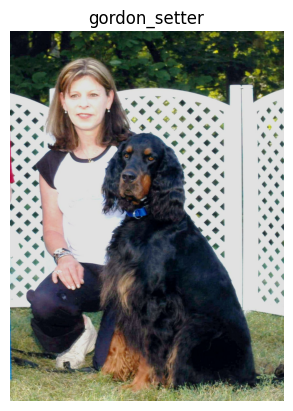

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(labels[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224, scale=False):
    """
    Converts image datatype from 'uint8' -> 'float32', reshapes image to
    [img_shape, img_shape, color_channels], and normalize it (optional)
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    if scale:
      image = image/255.
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 7 11 20]
  [ 8 12 21]
  [ 9 13 22]
  ...
  [44 45 29]
  [41 42 28]
  [38 39 25]]

 [[ 6 10 19]
  [ 7 11 20]
  [ 8 12 21]
  ...
  [44 45 29]
  [42 43 29]
  [40 41 27]]]...,
Shape: (1879, 1388, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 8.694197  12.694197  21.694197 ]
  [ 6.305804  10.305803  19.305803 ]
  [ 6.6969266 10.696926  19.696926 ]
  ...
  [85.12256   85.81676   51.816757 ]
  [51.56376   54.95215   31.646345 ]
  [41.305805  43.694195  27.       ]]

 [[ 5.4511914  9.451191  18.45119  ]
  [ 5.1883965  9.188396  18.188396 ]
  [ 5.9092207  9.909221  18.909222 ]
  ...
  [70.41294   78.41294   37.431007 ]
  [68.65473   78.65473   44.383667 ]
  [62.499344  72.53253   37.26779  ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch and prepocess data

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
validation_data = validation_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
validation_data = validation_data.batch(32).prefetch(tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, validation_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create model callbacks

In [ ]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "feature_extract_aug_checkpoints" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=False, # save the whole model
                                                      verbose=0)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=2)
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

## Augmentation

In [ ]:
# Create augmentation layer

data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2)
    ]
)

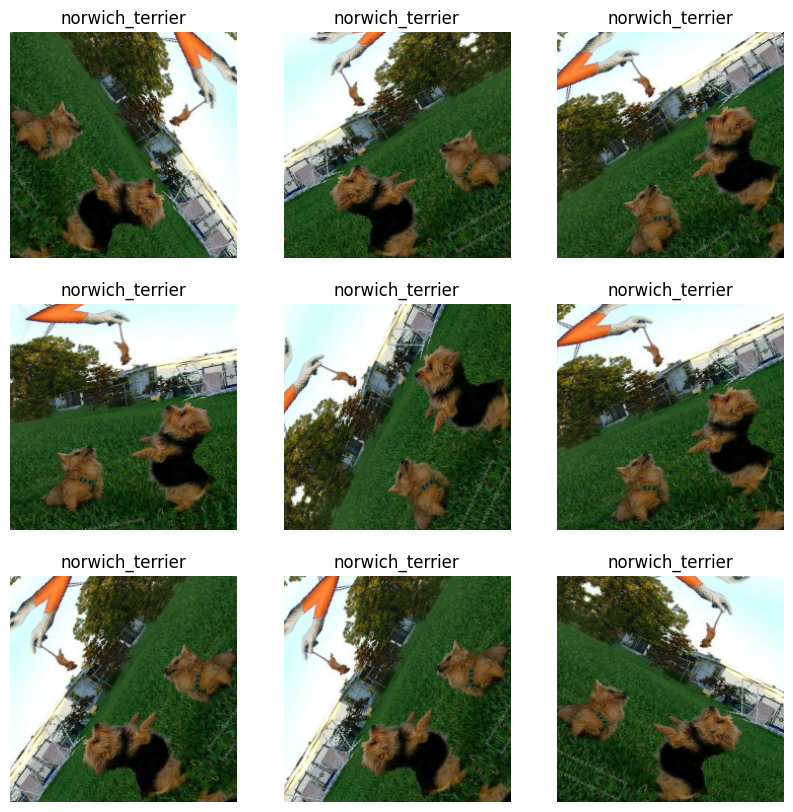

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for images, label in train_data.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(labels[label[0]])
        plt.axis("off")

## Turn on mixed precision learning

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision
mixed_precision.global_policy()

<Policy "mixed_float16">

## Create feature extraction model

In [ ]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2S(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # data augmentation layer
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(0.2)(x) # regulizer
x = layers.Dense(len(labels))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

82420632/82420632 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-s (Function  (None, None, None, 1280   20331360  
 al)                         )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 120)               153720    
                                                              

In [ ]:
# Check layers of the base model
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-s False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dropout True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## Train feature extraction model until convergence

In [ ]:
# Fit the model with callbacks
history_feature_extract_aug = model.fit(train_data,
                                    epochs=100,
                                    steps_per_epoch=len(train_data),
                                    validation_data=validation_data,
                                    validation_steps=int(len(validation_data)),
                                    callbacks=[create_tensorboard_callback("training_logs",
                                                                          "efficientnetv2s_feature_extract_aug"),
                                               early_stopping,
                                               reduce_lr,
                                              model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetv2s_feature_extract_aug/20231117-190640
Epoch 1/100
375/375 [==============================] - 121s 255ms/step - loss: 1.0198 - accuracy: 0.8428 - val_loss: 0.2842 - val_accuracy: 0.9215 - lr: 0.0010
Epoch 2/100
375/375 [==============================] - 97s 256ms/step - loss: 0.2730 - accuracy: 0.9179 - val_loss: 0.2599 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 3/100
375/375 [==============================] - 34s 86ms/step - loss: 0.2205 - accuracy: 0.9308 - val_loss: 0.2521 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 4/100
375/375 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9417
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
375/375 [==============================] - 98s 259ms/step - loss: 0.1853 - accuracy: 0.9417 - val_loss: 0.2526 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 5/100
375/375 [==============================] - 109s 285ms/step - loss: 0.1458 - accuracy: 0.954

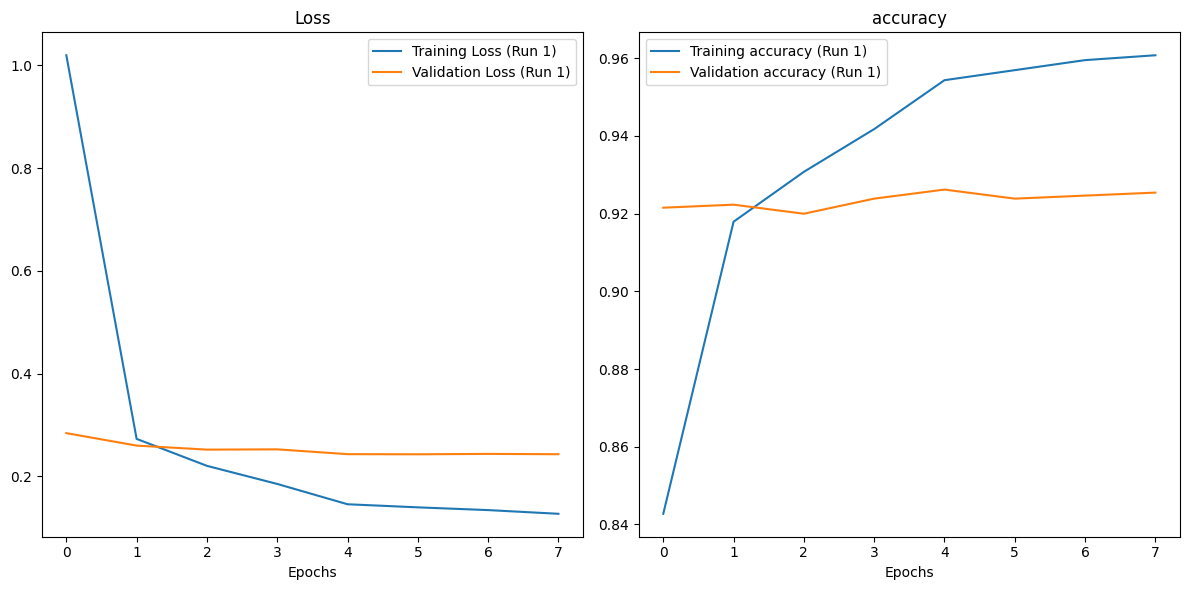

In [ ]:
plot_loss_curves(history_feature_extract_aug)

In [ ]:
import os
from google.colab import files as colab_files  # Rename the module to avoid conflict

def download_directory_contents(directory_path):
    for root, dirs, files_list in os.walk(directory_path):
        for file in files_list:
            file_path = os.path.join(root, file)
            colab_files.download(file_path)  # Use the renamed module here

In [ ]:
# Save the feature extractrion model
download_directory_contents("/content/feature_extract_aug_checkpoints")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save feature extraction training logs
download_directory_contents("/content/training_logs")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Prepare model for fine tuning (unfreezing layers)

In [ ]:
# Set all layers to trainable
for layer in model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetv2-s True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dropout True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## Create model callbacks for fine tuning

In [ ]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "fine_tune_aug_checkpoints" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=False, # save the whole model
                                                      verbose=0)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=2)
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

## Build fine tune model

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(0.00005), # 15x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_fine_tune = model.fit(train_data,
                                      epochs=100, # fine-tune for a maximum of 100 epochs
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(len(validation_data)), # validation during training on 15% of test data
                                      callbacks=[create_tensorboard_callback("training_logs", "efficientv2s_fine_tuning"), # track the model training logs
                                      model_checkpoint, # save only the best model during training
                                      early_stopping, # stop model after X epochs if no improvements
                                      reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientv2s_fine_tuning/20231117-192202
Epoch 1/100
375/375 [==============================] - 280s 467ms/step - loss: 0.1949 - accuracy: 0.9320 - val_loss: 0.3281 - val_accuracy: 0.8948 - lr: 5.0000e-05
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9736
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
375/375 [==============================] - 174s 459ms/step - loss: 0.0820 - accuracy: 0.9736 - val_loss: 0.3489 - val_accuracy: 0.9032 - lr: 5.0000e-05
Epoch 3/100
375/375 [==============================] - 181s 479ms/step - loss: 0.0308 - accuracy: 0.9902 - val_loss: 0.3183 - val_accuracy: 0.9093 - lr: 1.0000e-05
Epoch 4/100
375/375 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9949
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
375/375 [==============================] - 178s 472ms/step - loss: 0.0163 - accuracy:

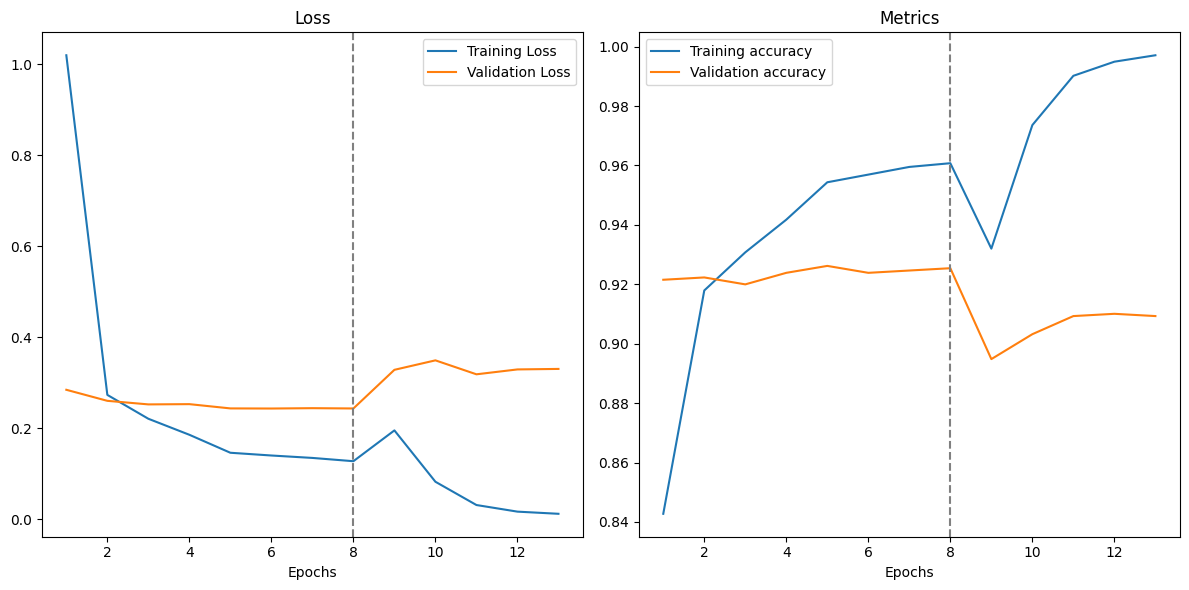

In [ ]:
plot_loss_curves([history_feature_extract_aug, history_fine_tune], finetune=True)

In [ ]:
# Save the fine tuned model
download_directory_contents("/content/fine_tune_aug_checkpoints")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save fine tune training logs
download_directory_contents("/content/training_logs/efficientv2s_fine_tuning")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## More augmentation

Model is Overfitting alot, let's try again, but this time include even more augmentation on the data...hope to fix the overfitting

In [ ]:
# Create augmentation layer

data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.2),
        layers.RandomWidth(0.2)
    ], name="data_augmentation"
)

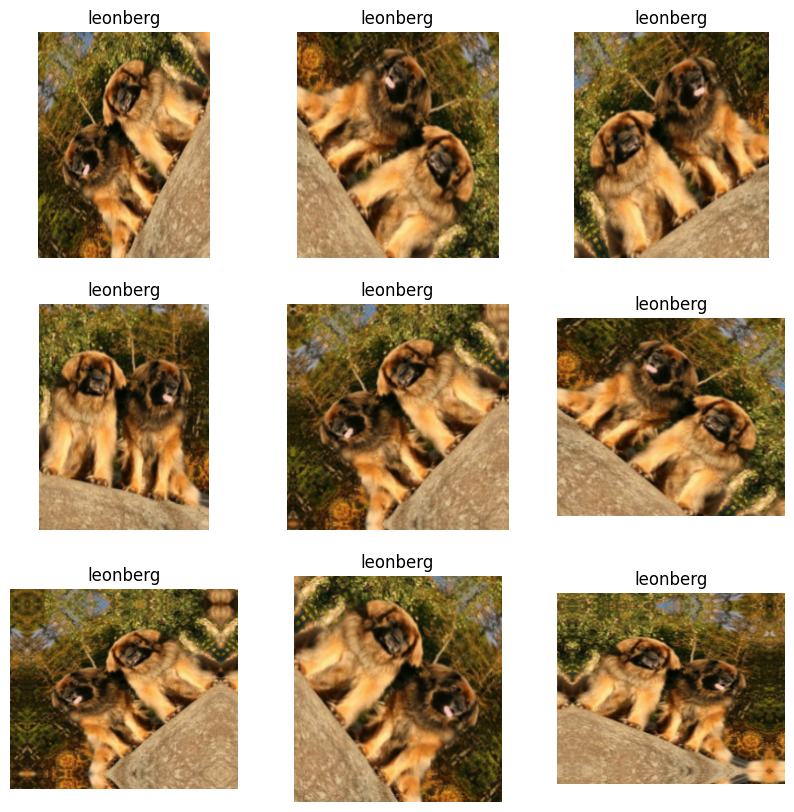

In [ ]:
# Visualize data augmentation

import numpy as np
import matplotlib.pyplot as plt

for images, label in train_data.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(labels[label[0]])
        plt.axis("off")

In [ ]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "feature_extract_aug_checkpoints_02" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=False, # save the whole model
                                                      verbose=0)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=2)
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2S(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # data augmentation layer
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(0.2)(x) # regulizer
x = layers.Dense(len(labels))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

82420632/82420632 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-s (Function  (None, None, None, 1280   20331360  
 al)                         )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 120)               153720    
                                                              

In [ ]:
# Check layers of the base model
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-s False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dropout True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Fit the model with callbacks
history_feature_extract_aug = model.fit(train_data,
                                    epochs=100,
                                    steps_per_epoch=len(train_data),
                                    validation_data=validation_data,
                                    validation_steps=int(len(validation_data)),
                                    callbacks=[create_tensorboard_callback("training_logs",
                                                                          "efficientnetv2s_feature_extract_aug_2"),
                                               early_stopping,
                                               reduce_lr,
                                              model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetv2s_feature_extract_aug_2/20231118-154927
Epoch 1/100
375/375 [==============================] - 117s 249ms/step - loss: 1.0394 - accuracy: 0.8359 - val_loss: 0.2935 - val_accuracy: 0.9099 - lr: 0.0010
Epoch 2/100
375/375 [==============================] - 93s 245ms/step - loss: 0.2739 - accuracy: 0.9191 - val_loss: 0.2636 - val_accuracy: 0.9145 - lr: 0.0010
Epoch 3/100
375/375 [==============================] - 96s 252ms/step - loss: 0.2219 - accuracy: 0.9317 - val_loss: 0.2554 - val_accuracy: 0.9192 - lr: 0.0010
Epoch 4/100
375/375 [==============================] - 91s 241ms/step - loss: 0.1860 - accuracy: 0.9420 - val_loss: 0.2542 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 5/100
375/375 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9504
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
375/375 [==============================] - 34s 86ms/step - loss: 0.1598 - accuracy: 0.95

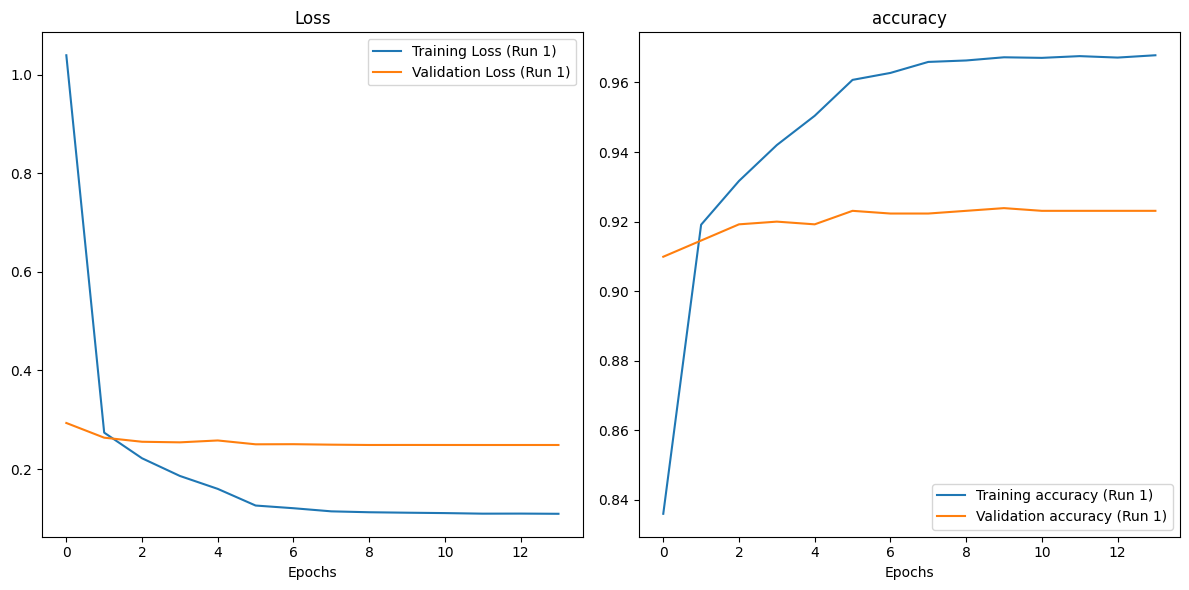

In [ ]:
plot_loss_curves(history_feature_extract_aug)

In [ ]:
# Set all layers to trainable
for layer in model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetv2-s True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dropout True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "fine_tune_aug_checkpoints" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=False, # save the whole model
                                                      verbose=0)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=2)
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(0.00005), # 15x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_fine_tune = model.fit(train_data,
                                      epochs=100, # fine-tune for a maximum of 100 epochs
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(len(validation_data)), # validation during training on 15% of test data
                                      callbacks=[create_tensorboard_callback("training_logs", "efficientv2s_fine_tuning"), # track the model training logs
                                      model_checkpoint, # save only the best model during training
                                      early_stopping, # stop model after X epochs if no improvements
                                      reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientv2s_fine_tuning/20231118-160623
Epoch 1/100
375/375 [==============================] - 284s 474ms/step - loss: 0.1825 - accuracy: 0.9352 - val_loss: 0.3168 - val_accuracy: 0.8979 - lr: 5.0000e-05
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9731
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
375/375 [==============================] - 173s 457ms/step - loss: 0.0820 - accuracy: 0.9731 - val_loss: 0.3426 - val_accuracy: 0.9009 - lr: 5.0000e-05
Epoch 3/100
375/375 [==============================] - 176s 466ms/step - loss: 0.0295 - accuracy: 0.9915 - val_loss: 0.2978 - val_accuracy: 0.9131 - lr: 1.0000e-05
Epoch 4/100
375/375 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9967
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
375/375 [==============================] - 99s 261ms/step - loss: 0.0148 - accuracy: 

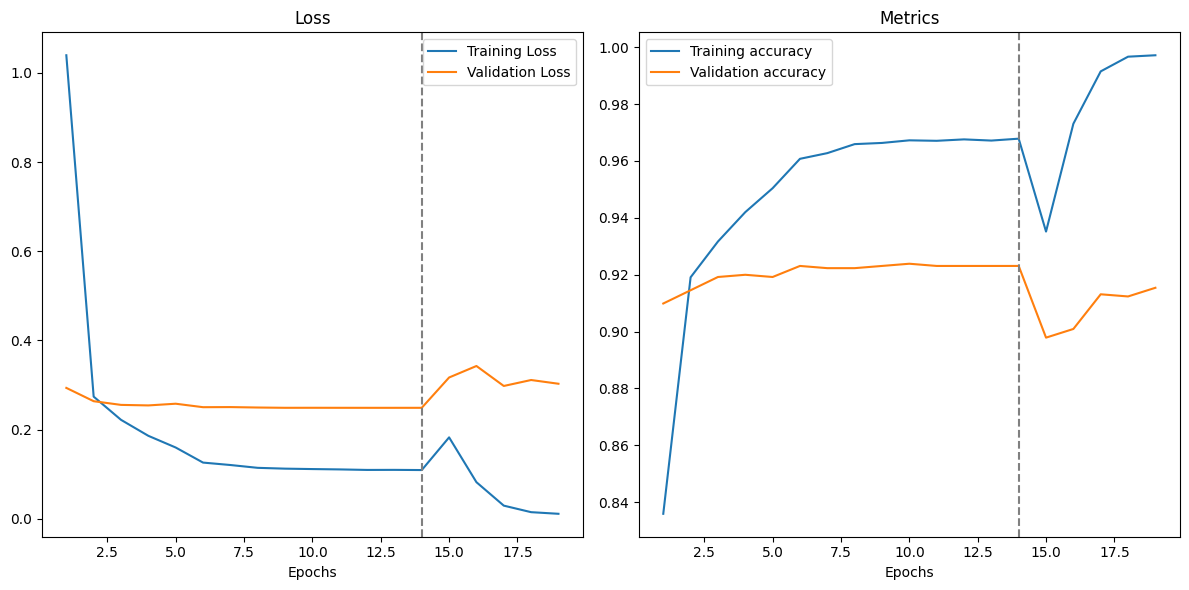

In [ ]:
plot_loss_curves([history_feature_extract_aug, history_fine_tune], finetune=True)

## L2 Regulizer
That didn't do the trick, let's try adding the L2 regulizer to tackle the overfitting. As well as adding the dense layer with ReLu activation after the average pooling layer.

In [ ]:
# Create augmentation layer

data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.2),
        layers.RandomWidth(0.2)
    ], name="data_augmentation"
)

In [ ]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "feature_extract_aug_checkpoints_03" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=False, # save the whole model
                                                      verbose=0)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=2)
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
# Create base model 02
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2S(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # data augmentation layer
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(128, activation="relu")(x) # Add aditional Dense layer
x = layers.Dropout(0.2)(x)

x = layers.Dense(units=len(labels), kernel_regularizer=tf.keras.regularizers.L2(0.005))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

82420632/82420632 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-s (Function  (None, None, None, 1280   20331360  
 al)                         )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                              

In [ ]:
# Check layers of the base model
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-s False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
dropout True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Fit the model with callbacks
history_feature_extract_aug_l2 = model.fit(train_data,
                                    epochs=100,
                                    steps_per_epoch=len(train_data),
                                    validation_data=validation_data,
                                    validation_steps=int(len(validation_data)),
                                    callbacks=[create_tensorboard_callback("training_logs",
                                                                          "efficientnetv2s_feature_extract_aug_l2"),
                                               early_stopping,
                                               reduce_lr,
                                              model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetv2s_feature_extract_aug_l2/20231119-230219
Epoch 1/100
375/375 [==============================] - 140s 274ms/step - loss: 1.6278 - accuracy: 0.8177 - val_loss: 0.7345 - val_accuracy: 0.9114 - lr: 0.0010
Epoch 2/100
375/375 [==============================] - 101s 266ms/step - loss: 0.7210 - accuracy: 0.8986 - val_loss: 0.5855 - val_accuracy: 0.9122 - lr: 0.0010
Epoch 3/100
375/375 [==============================] - 39s 98ms/step - loss: 0.5865 - accuracy: 0.9084 - val_loss: 0.5236 - val_accuracy: 0.9122 - lr: 0.0010
Epoch 4/100
375/375 [==============================] - 35s 90ms/step - loss: 0.5188 - accuracy: 0.9131 - val_loss: 0.4797 - val_accuracy: 0.9091 - lr: 0.0010
Epoch 5/100
375/375 [==============================] - 37s 92ms/step - loss: 0.4705 - accuracy: 0.9186 - val_loss: 0.4705 - val_accuracy: 0.9099 - lr: 0.0010
Epoch 6/100
375/375 [==============================] - 101s 266ms/step - loss: 0.4409 - accuracy: 0.9206

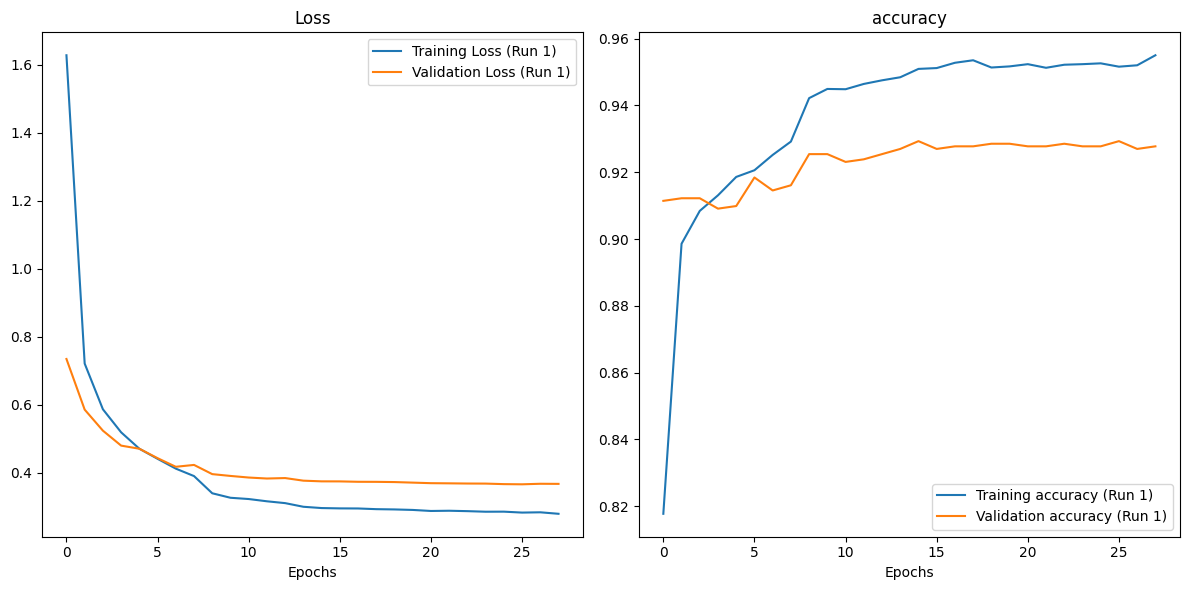

In [ ]:
plot_loss_curves(history_feature_extract_aug_l2)

In [ ]:
import os
from google.colab import files as colab_files  # Rename the module to avoid conflict

def download_directory_contents(directory_path):
    for root, dirs, files_list in os.walk(directory_path):
        for file in files_list:
            file_path = os.path.join(root, file)
            colab_files.download(file_path)  # Use the renamed module here

In [ ]:
# Save the feature extractrion model
download_directory_contents("/content/feature_extract_aug_checkpoints_03")
# Save the training logs
download_directory_contents("/content/training_logs")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
# Set all layers to trainable
for layer in model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetv2-s True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
dropout True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "fine_tune_aug_checkpoints" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=False, # save the whole model
                                                      verbose=0)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=2)
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(1e-5), # lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_fine_tune = model.fit(train_data,
                                      epochs=100, # fine-tune for a maximum of 100 epochs
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(len(validation_data)), # validation during training on 15% of test data
                                      callbacks=[create_tensorboard_callback("training_logs", "efficientv2s_fine_tuning"), # track the model training logs
                                      model_checkpoint, # save only the best model during training
                                      early_stopping, # stop model after X epochs if no improvements
                                      reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientv2s_fine_tuning/20231119-232842
Epoch 1/100
375/375 [==============================] - 293s 488ms/step - loss: 0.2768 - accuracy: 0.9495 - val_loss: 0.3766 - val_accuracy: 0.9223 - lr: 1.0000e-05
Epoch 2/100
375/375 [==============================] - 185s 491ms/step - loss: 0.2200 - accuracy: 0.9688 - val_loss: 0.3761 - val_accuracy: 0.9261 - lr: 1.0000e-05
Epoch 3/100
375/375 [==============================] - 183s 486ms/step - loss: 0.1908 - accuracy: 0.9786 - val_loss: 0.3750 - val_accuracy: 0.9306 - lr: 1.0000e-05
Epoch 4/100
375/375 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.9856
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
375/375 [==============================] - 188s 495ms/step - loss: 0.1688 - accuracy: 0.9856 - val_loss: 0.3870 - val_accuracy: 0.9314 - lr: 1.0000e-05
Epoch 5/100
375/375 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.99

In [ ]:
# Save the feature extractrion model
download_directory_contents("/content/fine_tune_aug_checkpoints")
# Save the training logs
download_directory_contents("/content/training_logs/efficientv2s_fine_tuning")

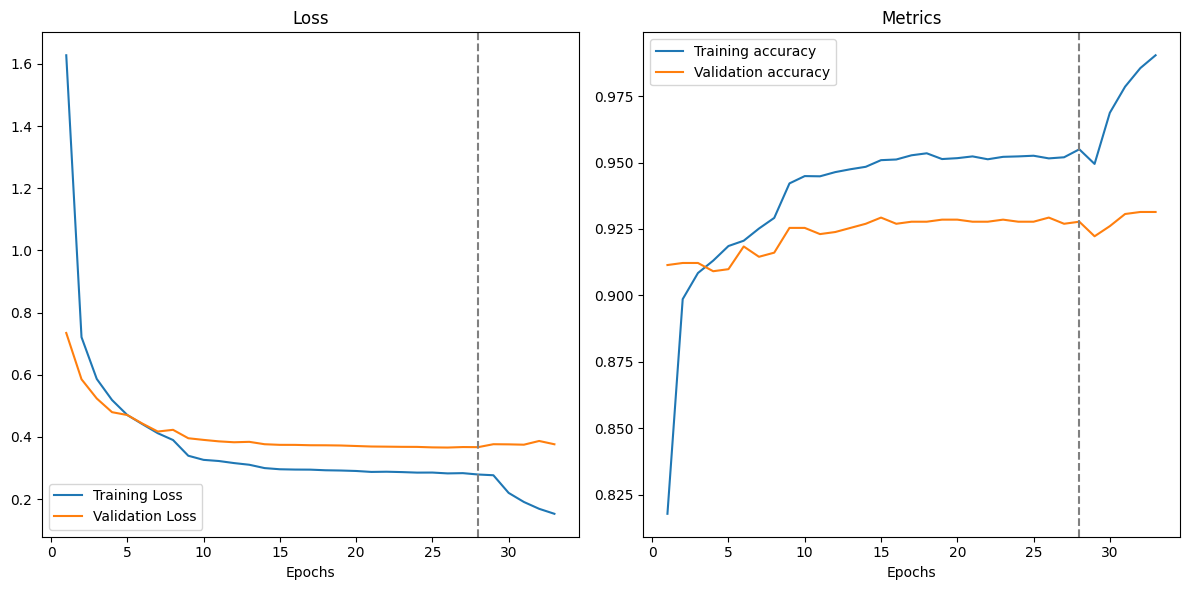

In [ ]:
plot_loss_curves([history_feature_extract_aug_l2, history_fine_tune], finetune=True)

## Try better model

In [ ]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "feature_extract_aug_checkpoints_better" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=False, # save the whole model
                                                      verbose=0)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=2)
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # data augmentation layer
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(128, activation="relu")(x) # Add aditional Dense layer
x = layers.Dropout(0.2)(x)

x = layers.Dense(units=len(labels), kernel_regularizer=tf.keras.regularizers.L2(0.005))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

52606240/52606240 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1536)              0         
 gePooling2D)                                                    
                                                                 
 dense_2 (Dense)             (None, 128)               196736    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                            

In [ ]:
# Fit the model with callbacks
history_feature_extract_aug_EV2B3 = model.fit(train_data,
                                    epochs=100,
                                    steps_per_epoch=len(train_data),
                                    validation_data=validation_data,
                                    validation_steps=int(len(validation_data)),
                                    callbacks=[create_tensorboard_callback("training_logs",
                                                                          "efficientnetv2b3_feature_extract_aug_l2"),
                                               early_stopping,
                                               reduce_lr,
                                              model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetv2b3_feature_extract_aug_l2/20231120-000556
Epoch 1/100
375/375 [==============================] - 112s 253ms/step - loss: 1.5988 - accuracy: 0.8108 - val_loss: 0.7120 - val_accuracy: 0.9122 - lr: 0.0010
Epoch 2/100
375/375 [==============================] - 86s 223ms/step - loss: 0.6693 - accuracy: 0.9061 - val_loss: 0.5630 - val_accuracy: 0.9130 - lr: 0.0010
Epoch 3/100
375/375 [==============================] - 89s 233ms/step - loss: 0.5284 - accuracy: 0.9227 - val_loss: 0.4992 - val_accuracy: 0.9145 - lr: 0.0010
Epoch 4/100
375/375 [==============================] - 87s 228ms/step - loss: 0.4564 - accuracy: 0.9313 - val_loss: 0.4521 - val_accuracy: 0.9153 - lr: 0.0010
Epoch 5/100
375/375 [==============================] - 32s 83ms/step - loss: 0.4095 - accuracy: 0.9379 - val_loss: 0.4426 - val_accuracy: 0.9145 - lr: 0.0010
Epoch 6/100
375/375 [==============================] - 32s 82ms/step - loss: 0.3787 - accuracy: 0.9413

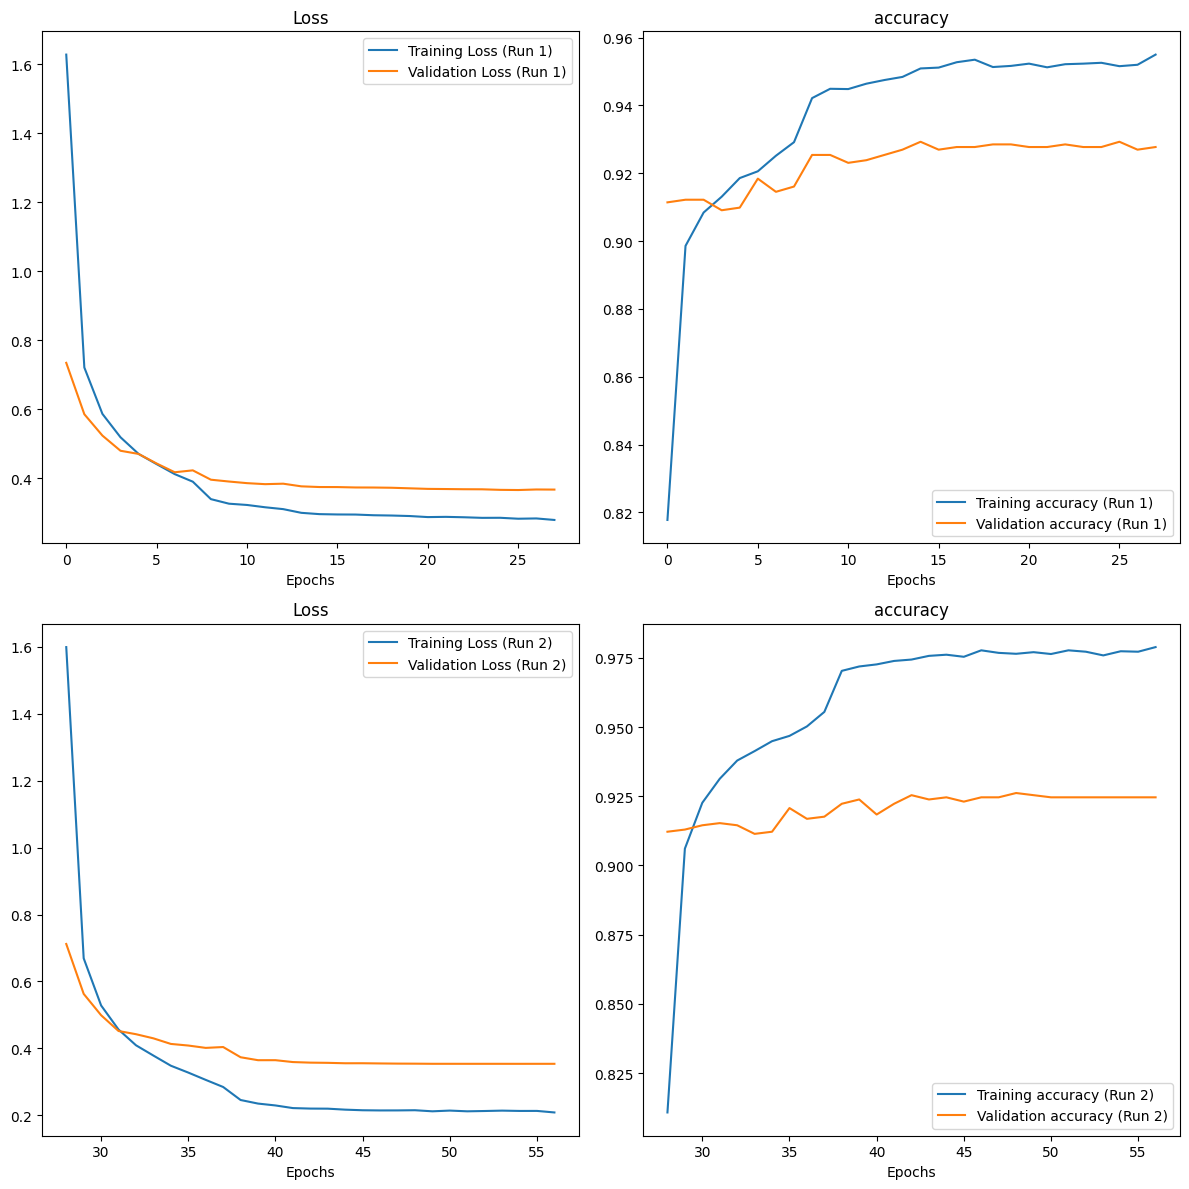

In [ ]:
plot_loss_curves([history_feature_extract_aug_l2, history_feature_extract_aug_EV2B3])